<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Pneumonia Detection using X-Ray Images</b></div>

In [1]:
!nvidia-smi


Wed May  1 18:06:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P0              20W /  80W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a id="lib"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Importing Required Libraries</b></div> 

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

from matplotlib import rcParams

import matplotlib.patches as patches
from math import ceil

<a id="labels"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Loading Labels</b></div> 

In [3]:
label_data = pd.read_csv('data/stage_2_train_labels.csv')
columns = ['patientId', 'Target']
all_data = label_data

label_data = label_data.filter(columns)
label_data.head(5)
#print(all_data)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


<a id="split"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Spliting Train and Validation Sets</b></div> 

In [4]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [5]:
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')

patientId: 0bad22f7-1833-43bc-92ec-ac2aba6e1ef7, Target: 0


In [6]:
train_f = 'data/stage_2_train_images'
test_f = 'data/stage_2_test_images'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

27204
3023


<a id="sample"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Checking Some Samples from Dataset</b></div> 

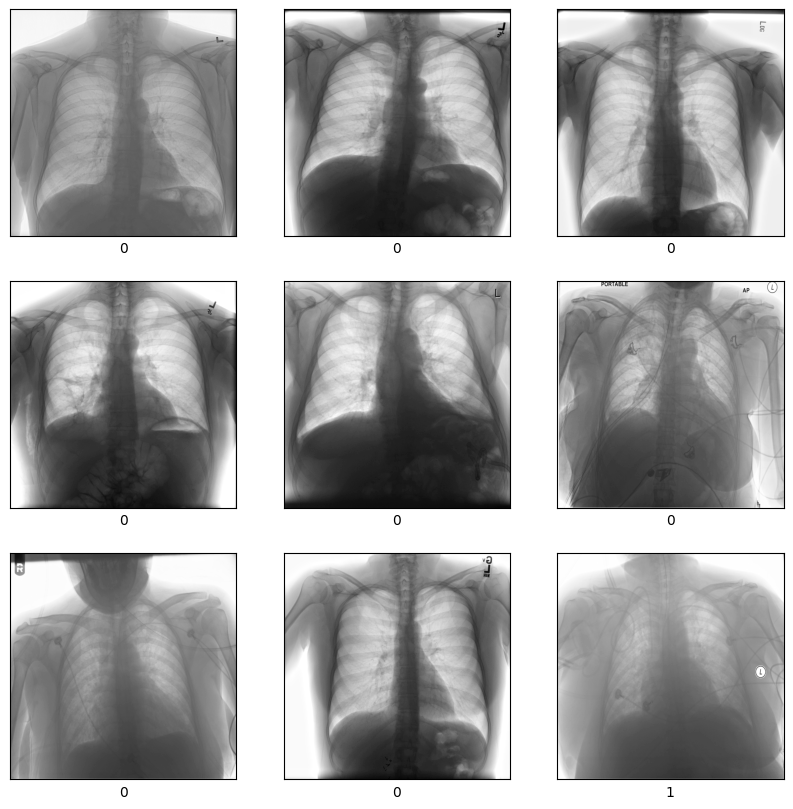

In [7]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

imshow()

<a id="trans"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Composing Transformations</b></div>  

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
    ])

<a id="data"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Writing a Custom Dataset Function</b></div>   

In [9]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
        
        
        name = self.paths[index].split("/")[-1]
        GH = all_data['patientId']==name
        FIL = all_data[GH]
        #print("From the datset loader, name", name)
        box = [FIL['x'].values[0], FIL['y'].values[0], FIL['width'].values[0], FIL['height'].values[0]]
            
        return image, label, box
    
    def __len__(self):
        
        return len(self.paths)

## Prepare training and validation dataloader

In [14]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

## Check dataloader

In [ ]:
batch = iter(train_loader)
images, labels, _ = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

## Specify device object

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
if 0:
    num_epochs = 20
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        # Training step
        for i, (images, labels, _) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        # Validation step
        correct = 0
        total = 0
        for images, labels, _ in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (labels == predicted).sum()
        print(f'Epoch: {epoch + 1}/{num_epochs}, Val_Acc: {100 * correct / total}')

In [ ]:
if 0:
    model.eval()

    correct = 0
    total = 0
    for images, labels, _ in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Val_Acc: {100 * correct / total}')

In [ ]:
#torch.save(model.state_dict(), 'model_weights/weights_only.pth')
#torch.save(model, 'model.pth')
#print("Model and weights saved.")

In [ ]:
model = torch.load('models/model.pth')

In [ ]:
model.eval()

correct = 0
total = 0  
for images, labels, _ in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')

100%|██████████| 24/24 [01:47<00:00,  4.50s/it]

Val_Acc: 98.84220886230469


torch.Size([224, 224, 3])
Label :  1 [618.0, 430.0, 243.0, 223.0]


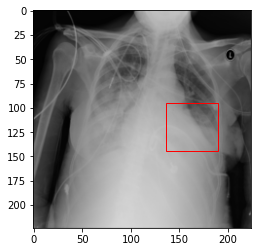

In [ ]:
# Load test image
label = 0
while(label==0):
    pil_img, label, box = next(image)

fig,ax = plt.subplots(1)

Orig_img_size = 1024
img_size = 224

# 'r' means relative. 'c' means center.
rx = ceil(box[0]*img_size/Orig_img_size)
ry = ceil(box[1]*img_size/Orig_img_size)
rw = ceil(box[2]*img_size/Orig_img_size)
rh = ceil(box[3]*img_size/Orig_img_size)


pil_img = np.transpose(pil_img, (1, 2, 0))
print(pil_img.shape)
rect = patches.Rectangle((rx, ry), rw, rh, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(pil_img)
ax.add_patch(rect)
print("Label : ", label, box)